<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [967]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

#### Load the file and overview the data

In [968]:
# Load the data
house = pd.read_csv('./housing.csv')

In [969]:
# A:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [970]:
house.shape

(1460, 81)

In [971]:
house.rename(columns={'1stFlrSF':'FirstFlrSF',
                      '2ndFlrSF':'SecondFlrSF', 
                      '3SsnPorch': 'ThreeSsnPorch'}, inplace=True)

In [972]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'Paved

In [973]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

#### Filtering only residential houses or zone only

In [974]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [975]:
Residential_house = house[house['MSZoning'].isin(['RH','RL','RP','RM','FV'])]

In [976]:
Residential_house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [977]:
Residential_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [978]:
Residential_house.shape

(1450, 81)

#### EDA - Cleaning Null

In [979]:
# Checking the null counts and percentage
check_null = list(zip(Residential_house.columns,
                      Residential_house.isnull().sum(),
                      np.round(Residential_house.isnull().sum()/Residential_house.shape[0],3)))
[x for x in check_null if x[1] !=0]

[('LotFrontage', 259, 0.179),
 ('Alley', 1361, 0.939),
 ('MasVnrType', 8, 0.006),
 ('MasVnrArea', 8, 0.006),
 ('BsmtQual', 37, 0.026),
 ('BsmtCond', 37, 0.026),
 ('BsmtExposure', 38, 0.026),
 ('BsmtFinType1', 37, 0.026),
 ('BsmtFinType2', 38, 0.026),
 ('Electrical', 1, 0.001),
 ('FireplaceQu', 681, 0.47),
 ('GarageType', 79, 0.054),
 ('GarageYrBlt', 79, 0.054),
 ('GarageFinish', 79, 0.054),
 ('GarageQual', 79, 0.054),
 ('GarageCond', 79, 0.054),
 ('PoolQC', 1443, 0.995),
 ('Fence', 1172, 0.808),
 ('MiscFeature', 1398, 0.964)]

##### Handling NAN for 'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature' columns

In [980]:
def fillna_func(column,replace_word):
    #print(Residential_house[column].value_counts(dropna=False))
    Residential_house[column].fillna(replace_word, axis=0, inplace=True)
    #print(Residential_house[column].value_counts(dropna=False))

In [981]:
# Replace nan value with NA for Alley column
fillna_func('Alley','NA')

/Users/nandar/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [982]:
Columns_NA = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
              'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual',
              'GarageCond','PoolQC','Fence','MiscFeature']

for x in Columns_NA:
    fillna_func(x,'NA')

In [983]:
# Replace nan value with None for MasVnrType column
Columns_None = ['MasVnrType']
for x in Columns_None:
    fillna_func(x,'None')

##### <b> Handling NAN for Electrical column </b>

In [984]:
Residential_house['Electrical'].value_counts(dropna=False)

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [985]:
Residential_house[Residential_house['Electrical'].isnull()==True].index

Int64Index([1379], dtype='int64')

In [986]:
# Drop the nan value from Electrical column since the ratio is 0.001
Residential_house.drop(Residential_house[Residential_house['Electrical'].isnull()==True].index,
                       axis=0, inplace=True)

/Users/nandar/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


##### <B>Replaceing NAN value with Mean values</b>

In [987]:
def fillmean_func(column):
    Residential_house[column].fillna(np.mean(Residential_house[column]), 
                                     axis=0, inplace=True)

In [988]:
Columns_Mean = ['LotFrontage','MasVnrArea','GarageYrBlt']

for x in Columns_Mean:
    fillmean_func(x)

In [989]:
# Checking again to confirm there is no null anymore
check_null = list(zip(Residential_house.columns,
                      Residential_house.isnull().sum(),
                      np.round(Residential_house.isnull().sum()/Residential_house.shape[0],3)))
[x for x in check_null if x[1] !=0]

[]

##### <b>General checking</b>

In [990]:
Residential_house.filter(like='?', axis=0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [991]:
Residential_house.filter(like='-', axis=0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [992]:
Residential_house.filter(like='$', axis=0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


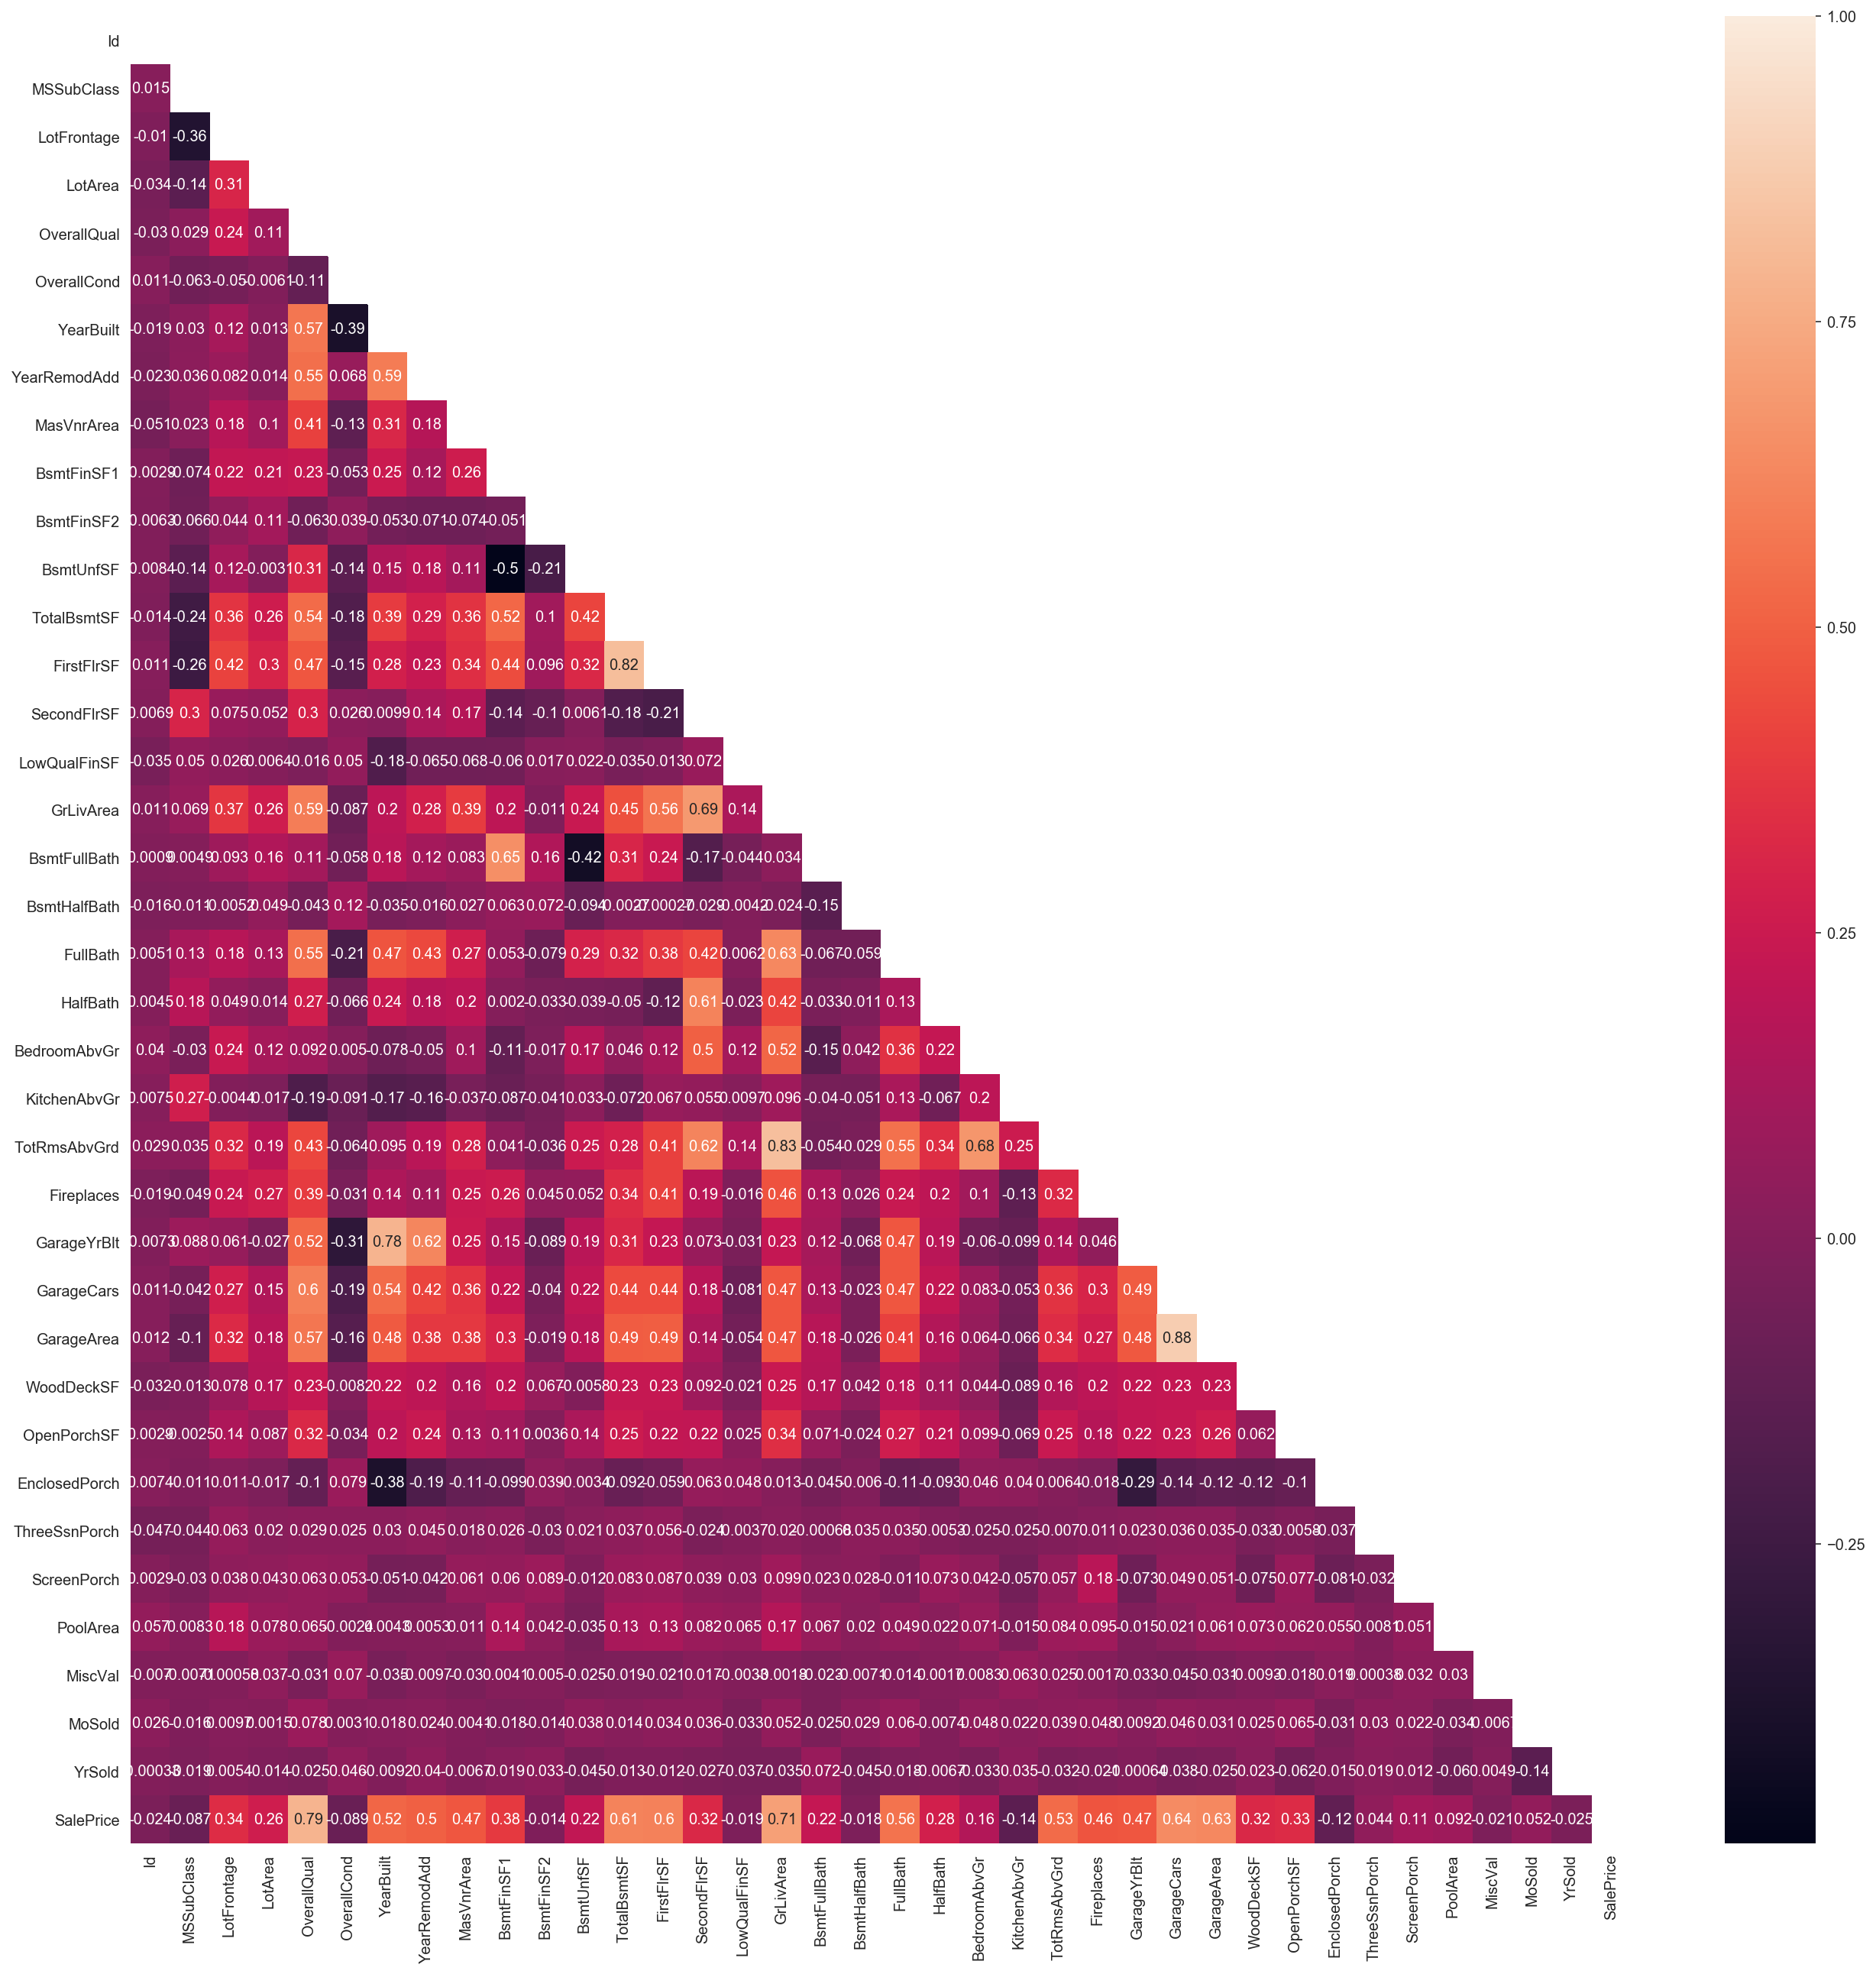

In [993]:
plt.figure(figsize=(22,22))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(Residential_house.corr(), dtype = np.bool )
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(Residential_house.corr( ), mask=mask, annot=True )

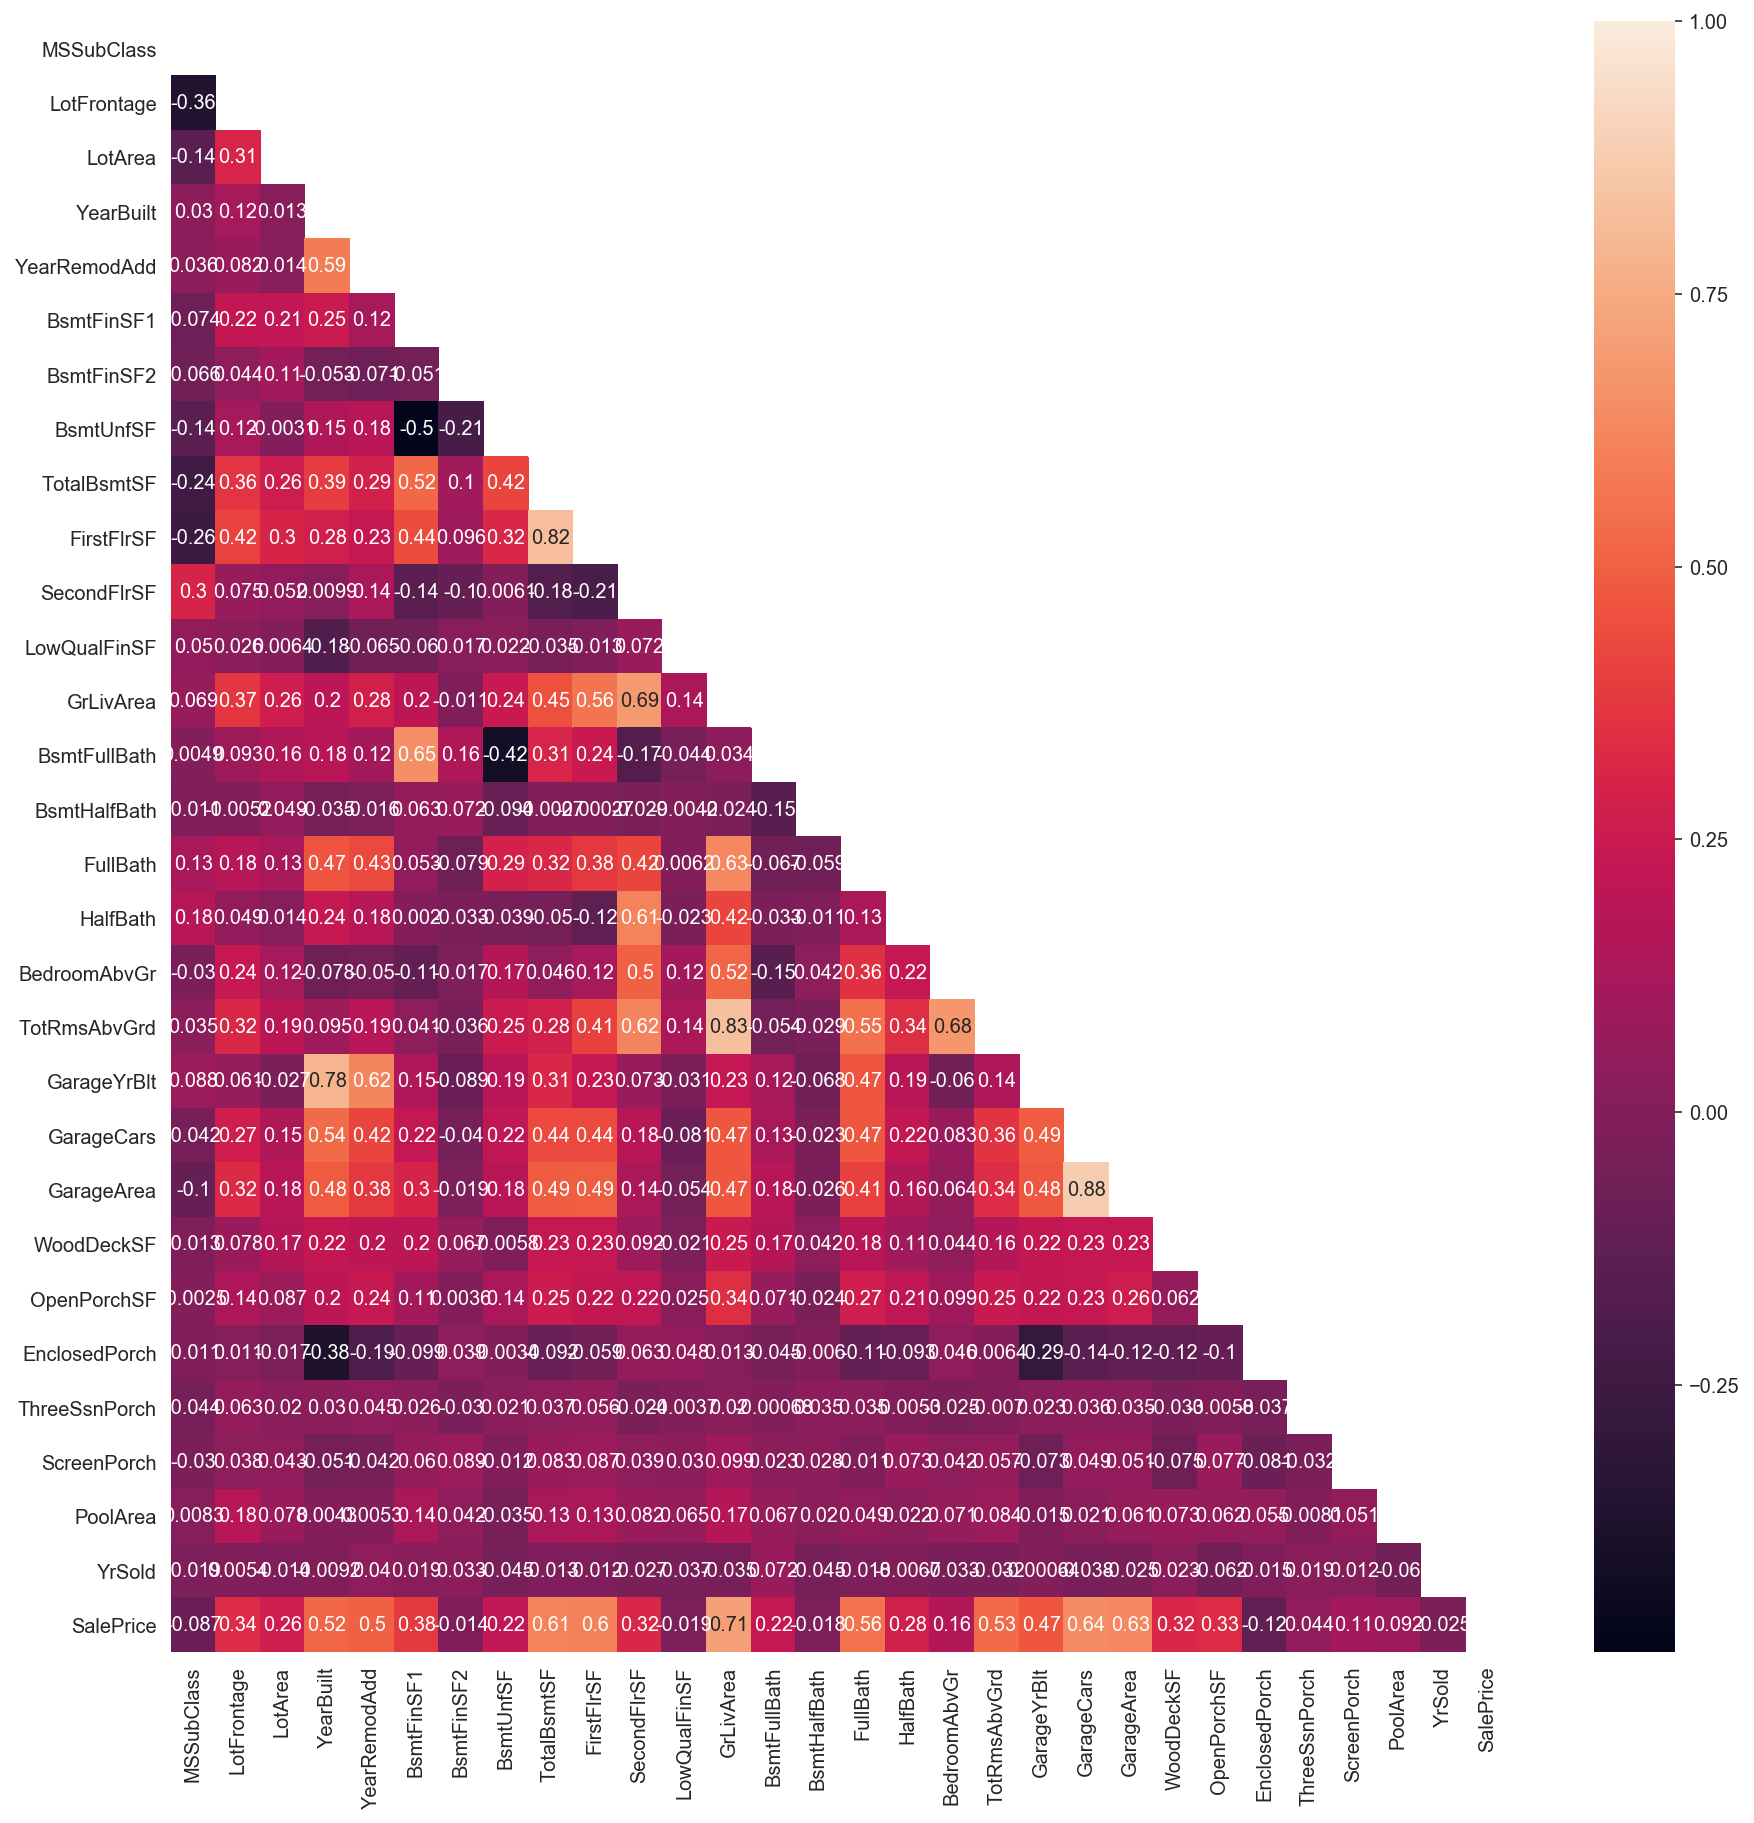

In [994]:
X = Residential_house[['MSSubClass','MSZoning','LotFrontage','LotArea','Street' 
          ,'Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood'
          ,'Condition1','Condition2','BldgType','YearBuilt','YearRemodAdd' 
          ,'Foundation','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF' 
          ,'FirstFlrSF','SecondFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath'
          ,'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd'
          ,'Functional','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF' 
          ,'OpenPorchSF','EnclosedPorch','ThreeSsnPorch','ScreenPorch','PoolArea'
          ,'YrSold','SaleType','SaleCondition','SalePrice']]

plt.figure(figsize=(15,15))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like( X.corr(), dtype = np.bool )
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap( X.corr( ), mask=mask, annot=True )


In [1025]:
# Computing IQR to handle outliers - still under progress
temp = Residential_house.copy()
temp['SalePrice'] = (temp['SalePrice']-np.mean(temp['SalePrice']))/np.std(temp['SalePrice'])
temp['LotArea'] = (temp['LotArea']-np.mean(temp['LotArea']))/np.std(temp['LotArea'])
# Q1 = temp['SalePrice'].quantile(0.25)
# Q3 = temp['SalePrice'].quantile(0.75)
# IQR = Q3 - Q1

# filtered = temp.query('(@Q1 - 1.5 * @IQR) <= SalePrice <= (@Q3 + 1.5 * @IQR)')


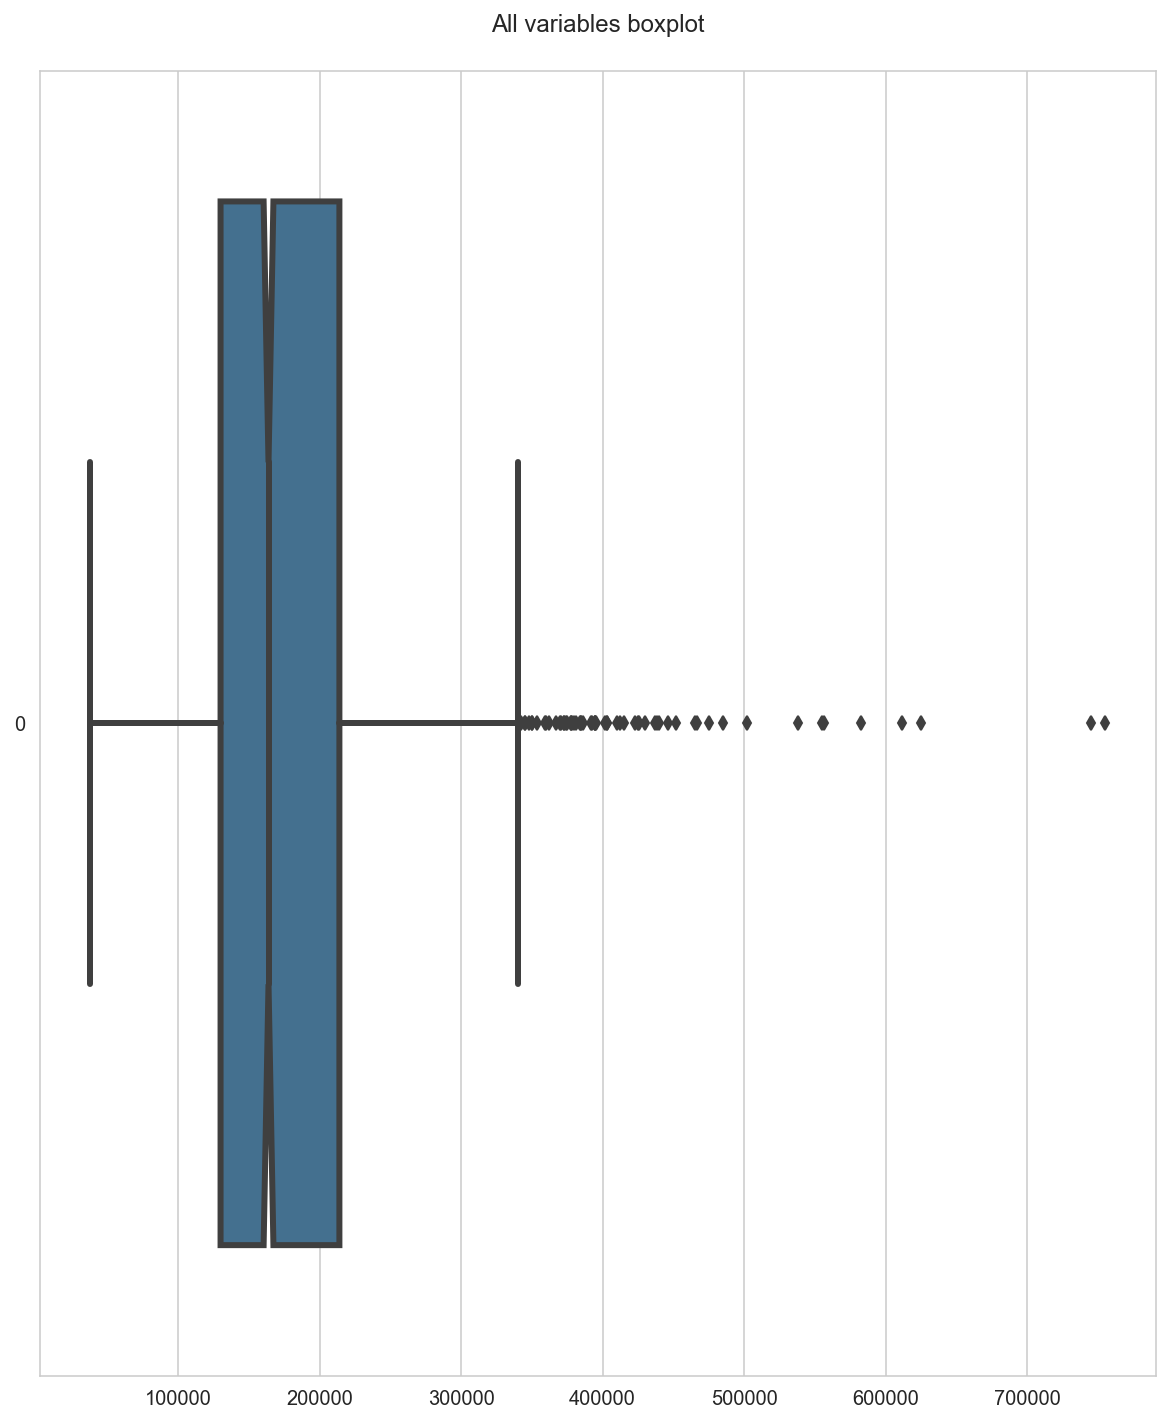

In [1029]:
# Checking outliers for Saleprice
fig = plt.figure(figsize=(10,12))
ax = fig.gca()
ax = sns.boxplot(data=Residential_house['SalePrice'], orient='h', fliersize=5, linewidth=3, notch=True, saturation=0.5, ax=ax)
ax.set_title('All variables boxplot\n')
plt.show()

#### Assigning non-renovateable features

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [997]:
# X includes non-renovateable features.
# check with others for Alley, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType
# MiscFeature, MiscVal
# X = Residential_house['MSSubClass','MSZoning','LotFrontage','LotArea','Street' 
#           ,'Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood'
#           ,'Condition1','Condition2','BldgType','YearBuilt','YearRemodAdd' 
#           ,'Foundation','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF' 
#           ,'FirstFlrSF','SecondFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath'
#           ,'BsmtHalfBath','FullBath','HalfBath','Bedroom','TotRmsAbvGrd'
#           ,'Functional','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF' 
#           ,'OpenPorchSF','EnclosedPorch','ThreeSsnPorch','ScreenPorch','PoolArea'
#           ,'YrSold','SaleType','SaleCondition']

formula = 'SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street \
          + Alley + LotShape + LandContour + LotConfig + LandSlope + Neighborhood \
          + Condition1 + Condition2 + BldgType + YearBuilt + YearRemodAdd \
          + Foundation + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF \
          + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath \
          + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + TotRmsAbvGrd \
          + Functional + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF \
          + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea \
          + YrSold + SaleType + SaleCondition - 1'

y, X = patsy.dmatrices(formula, data=Residential_house, return_type='dataframe')

In [998]:
list(X.columns)

['MSZoning[FV]',
 'MSZoning[RH]',
 'MSZoning[RL]',
 'MSZoning[RM]',
 'Street[T.Pave]',
 'Alley[T.NA]',
 'Alley[T.Pave]',
 'LotShape[T.IR2]',
 'LotShape[T.IR3]',
 'LotShape[T.Reg]',
 'LandContour[T.HLS]',
 'LandContour[T.Low]',
 'LandContour[T.Lvl]',
 'LotConfig[T.CulDSac]',
 'LotConfig[T.FR2]',
 'LotConfig[T.FR3]',
 'LotConfig[T.Inside]',
 'LandSlope[T.Mod]',
 'LandSlope[T.Sev]',
 'Neighborhood[T.Blueste]',
 'Neighborhood[T.BrDale]',
 'Neighborhood[T.BrkSide]',
 'Neighborhood[T.ClearCr]',
 'Neighborhood[T.CollgCr]',
 'Neighborhood[T.Crawfor]',
 'Neighborhood[T.Edwards]',
 'Neighborhood[T.Gilbert]',
 'Neighborhood[T.IDOTRR]',
 'Neighborhood[T.MeadowV]',
 'Neighborhood[T.Mitchel]',
 'Neighborhood[T.NAmes]',
 'Neighborhood[T.NPkVill]',
 'Neighborhood[T.NWAmes]',
 'Neighborhood[T.NoRidge]',
 'Neighborhood[T.NridgHt]',
 'Neighborhood[T.OldTown]',
 'Neighborhood[T.SWISU]',
 'Neighborhood[T.Sawyer]',
 'Neighborhood[T.SawyerW]',
 'Neighborhood[T.Somerst]',
 'Neighborhood[T.StoneBr]',
 'Neighbo

In [999]:
len(X.columns)

115

In [1000]:
X.rename(columns={'MSZoning[FV]':'MSZoning[T.FV]',
                  'MSZoning[RH]':'MSZoning[T.RH]', 
                  'MSZoning[RL]':'MSZoning[T.RL]',
                  'MSZoning[RM]':'MSZoning[T.RM]'}, inplace=True)

In [1001]:
def drop_dummy(column):
#     print(column,":")
#     print(Residential_house[column].value_counts(ascending=True))
    try:
        if column in Columns_NA: 
            drop_col_name = column + '[T.NA]'
            X.drop(drop_col_name, axis=1, inplace=True)
            print(column,":")
            print(Residential_house[column].value_counts(ascending=True))
            print("Drop column : {}".format(drop_col_name))
        elif column in Columns_None:
            drop_col_name = column + '[T.None]'
            X.drop(drop_col_name, axis=1, inplace=True)
            print(column,":")
            print(Residential_house[column].value_counts(ascending=True))
            print("Drop column : {}".format(drop_col_name))
        else:
            drop_col_name = column + '[T.' + Residential_house[column].\
                                            value_counts(ascending=True).index[0] + ']'
            X.drop(drop_col_name, axis=1, inplace=True)
            print(column,":")
            print(Residential_house[column].value_counts(ascending=True))
            print("Drop column : {}".format(drop_col_name))
    except:
        print(column," was performed drop_dummy.")
    print("_"*80)

In [1002]:
for x in X.columns:
    if 'T.' in x:
        drop_dummy(x.split('[')[0])

MSZoning :
RH      16
FV      65
RM     218
RL    1150
Name: MSZoning, dtype: int64
Drop column : MSZoning[T.RH]
________________________________________________________________________________
MSZoning  was performed drop_dummy.
________________________________________________________________________________
MSZoning  was performed drop_dummy.
________________________________________________________________________________
MSZoning  was performed drop_dummy.
________________________________________________________________________________
Street  was performed drop_dummy.
________________________________________________________________________________
Alley :
Pave      39
Grvl      50
NA      1360
Name: Alley, dtype: int64
Drop column : Alley[T.NA]
________________________________________________________________________________
Alley  was performed drop_dummy.
________________________________________________________________________________
LotShape :
IR3     10
IR2     41
IR1    483
Re

In [1003]:
len(X.columns)

101

In [1010]:
X['intercept'] = 1

In [1011]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
ss = StandardScaler()

# Use the "fit_transform" function to standardize the X design matrix.
Xs_train = ss.fit_transform(X_train)

linreg = LinearRegression()
linreg.fit(Xs_train, y_train)

/Users/nandar/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/nandar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nandar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1012]:
linreg.coef_

array([[-3.20638961e+03, -4.31070083e+03, -3.98947390e+03,
         9.81298754e+02, -3.92787824e+02,  2.10311848e+03,
         7.97780169e+02,  5.80106263e+03,  4.00362063e+03,
         1.70268636e+03, -1.97029092e+03, -7.22295791e+02,
         1.75409371e+03,  5.62239034e+01, -1.97900827e+03,
        -8.77746046e+00, -5.19254113e+03,  1.69703819e+03,
        -8.41423436e+03, -5.99259937e+03, -2.58117949e+03,
        -1.33445267e+03, -5.42277147e+03, -8.08643369e+03,
        -7.17801004e+02, -6.95614149e+03,  6.89306546e+03,
         1.25798615e+04, -7.53604183e+03, -3.26100407e+03,
        -5.14272481e+03, -3.59291276e+03,  2.31498432e+03,
         6.43175837e+03, -9.75441286e+02,  1.89866697e+03,
        -1.86530554e+03,  2.89071556e+03,  1.28119740e+03,
         9.86942777e+02, -8.64830736e+02,  4.59935876e+02,
         1.01436811e+03,  8.21342053e+02,  1.26551276e+03,
        -5.16301442e+03, -2.95346981e+02,  6.01938921e+02,
        -5.82837733e+12, -3.60972020e+03, -6.07353747e+0

In [1021]:
linreg.intercept_

array([183503.18805605])

In [1022]:
# Use the KFold class to add more options.
kf_shuffle = KFold(n_splits=5,shuffle=True, random_state=42) 

#The function cross_val_score returns the  𝑅2  for each testing set.
scores = cross_val_score(linreg, Xs_train, y_train, cv=kf_shuffle)

print(scores)
print(np.mean(scores), np.std(scores))

[-6.98748295e+18  7.33782799e-01 -2.12204026e+19 -3.51831428e+24
 -6.80735759e+21]
-7.05029968217118e+23 1.4066446176737682e+24


In [1023]:
predictions = linreg.predict(Xs_train)
print("RMSE for whole dataset:", np.sqrt(metrics.mean_squared_error(y_train, predictions)))

RMSE for whole dataset: 32396.20296156435


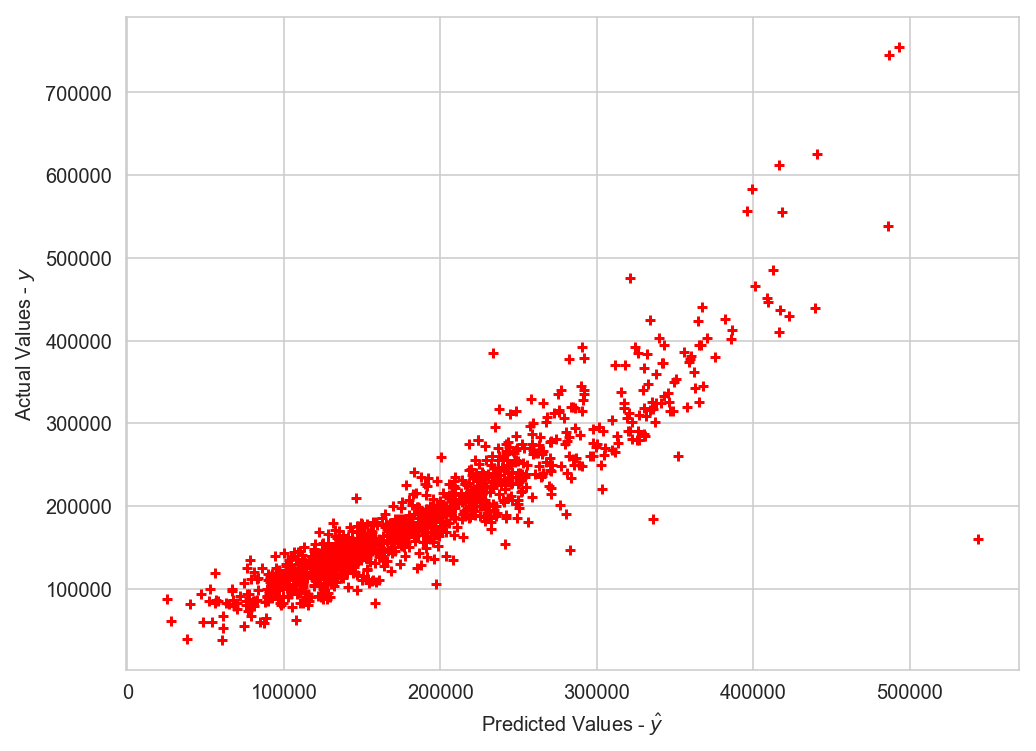

In [1024]:
# Plot the model with whole dataset
plt.figure(figsize=(8,6))
plt.scatter(predictions, y_train, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [1008]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [1009]:
# A: